# Test quality of matches

Import files

In [1]:
# The sys.stdout statements is to resolve proplems with printing statements in jupyter notebook, 
# when removed progress updates printed are not shown in the notebookr
import sys
stdout = sys.stdout

from ms2query.ms2library import MS2Library
sys.stdout = stdout

tanimoto_scores_df_file = "../downloads/gnps_210409/ALL_GNPS_210409_positive_tanimoto_scores.pickle"
sqlite_file =  "../downloads/gnps_210409/spectra/ALL_GNPS_210409_train_split.sqlite"

# Models
s2v_model_file = "../downloads/gnps_210409/models/ALL_GNPS_210409_Spec2Vec_ms2query.model"
ms2ds_model_file = "../downloads/gnps_210409/models/ms2ds_20210420-141937_data210409_10k_500_500_200.hdf5"

# Embeddings
s2v_embeddings_file =  "../downloads/gnps_210409/embeddings/s2v_embeddings_train_spectra_210426.pickle"
ms2ds_embeddings_file =  "../downloads/gnps_210409/embeddings/ms2ds_embeddings_train_spectra_210426.pickle"


### Split validation spectra into spectra with library matches and spectra without library matches
The validation spectra contain 2299 spectra (of 250 inchikeys) that do not have any match in the library and 2000 spectra that have at least one match in the library. 

In [3]:
from ms2query.utils import load_pickled_file

test_spectra = load_pickled_file("../downloads/gnps_210409/spectra/ALL_GNPS_210409_test_split.pickle")
test_spectra_without_match = test_spectra[:2250]
# validation_spectra = load_pickled_file("../downloads/gnps_210409/spectra/ALL_GNPS_210409_val_split.pickle")

# Plot tanimoto distribution results
To analyse the performance the tanimoto scores for the found matches are calculated. And the distribution is plotted to visualise the quality of the matches. 

In [21]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
from matplotlib import pyplot as plt
import numpy as np

def select_best_match_and_calculate_tanimoto_score(
    result_matches, tanimoto_scores_file, query_spectra, sqlite_file_location, select_on_MS2Query = True):
    """Returns a list with all the ms2query scores and tanimoto scores for the best matches"""
    
    tanimoto_scores = load_pickled_file(tanimoto_scores_file)
    ms2query_scores_and_tanimoto = []
    
    for query_spectrum in query_spectra:
        query_spectrum_id = query_spectrum.get("spectrumid")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        if select_on_MS2Query:
            best_match = result_matches[query_spectrum_id].iloc[0]
            best_match_score = best_match.loc["ms2query_model_prediction"]
            best_match_spectrum_id = best_match.name

        else:
            # Selection on highest MS2Deepscore
            best_match_spectrum_id = result_matches[query_spectrum_id]["ms2ds_score"].idxmax()
            best_match_score = result_matches[query_spectrum_id]["ms2ds_score"].max()

        best_match_inchikey = get_metadata_from_sqlite(
            sqlite_file_location, [best_match_spectrum_id], "spectrumid")[best_match_spectrum_id]["inchikey"][:14]
        tanimoto_score = tanimoto_scores.loc[best_match_inchikey, query_spectrum_inchikey]
        
        ms2query_scores_and_tanimoto.append((best_match_score, tanimoto_score))
    return ms2query_scores_and_tanimoto
        

def plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_scores_and_tanimoto, cut_offs, legend_title):
    bins = np.linspace(0, 1, 11)

    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)

    for cut_off in cut_offs:
        selected_scores = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off]
        print(len(selected_scores)/len(ms2query_scores_and_tanimoto))
        weights = [weight_to_convert_to_percentage] * len(selected_scores)
        
        plt.hist(selected_scores, bins, label = f"{cut_off:.2f}", weights = weights, histtype = "step")
    
    plt.legend(loc = "upper center", title = legend_title, ncol = 3)
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 25)

    plt.show

def compare_tanimoto_score_distribution(ms2query_scores_and_tanimoto, ms2deepscore_scores_and_tanimoto, cut_off_ms2q, cut_off_ms2d):
    bins = np.linspace(0, 1, 11)

    
    # Select scores for ms2query
    selected_scores_ms2q = [scores[1] for scores in ms2query_scores_and_tanimoto if scores[0] > cut_off_ms2q]
    ms2q_percentage_selected = len(selected_scores_ms2q)/len(ms2query_scores_and_tanimoto)*100
    print(ms2q_percentage_selected)
    weight_to_convert_to_percentage = 100/len(ms2query_scores_and_tanimoto)
    weights_ms2q = [weight_to_convert_to_percentage] * len(selected_scores_ms2q)

    # Select scores for ms2ds
    selected_scores_ms2d = [scores[1] for scores in ms2deepscore_scores_and_tanimoto if scores[0] > cut_off_ms2d]
    ms2d_percentage_selected = len(selected_scores_ms2d)/len(ms2deepscore_scores_and_tanimoto)*100
    print(ms2d_percentage_selected)
    weight_to_convert_to_percentage = 100/len(ms2deepscore_scores_and_tanimoto)
    weights_ms2d = [weight_to_convert_to_percentage] * len(selected_scores_ms2d)
    
    
    plt.hist([selected_scores_ms2d, selected_scores_ms2q], bins, label = ["MS2Deepscore", "MS2Query"], weights = [weights_ms2d, weights_ms2q])
    
    plt.legend(loc = "upper center", title = "Select on:")
    plt.xlabel("tanimoto_score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0, 15)

    plt.show

In [4]:
# results_test_spectra_file = "../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra.pickle"
results_test_spectra_file = "../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra_dropout_reg.pickle"

results = load_pickled_file(results_test_spectra_file)

# Calculate tanimoto scores of found matches based on MS2Query
ms2query_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file)
# Calculate tanimoto scores of found matches based on MS2Deepscore
ms2ds_and_tanimoto = select_best_match_and_calculate_tanimoto_score(
    results, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file, False)

20.044444444444444
19.955555555555556


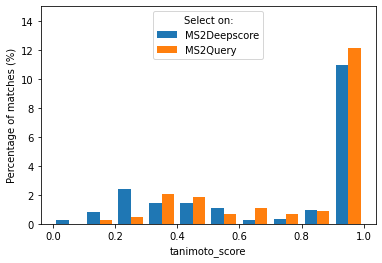

In [57]:
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0,0.6,0.75,0.9], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0,0.93,0.97, 0.99], "Minimal MS2Deepscore")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0.753], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0.9415], "Minimal MS2Deepscore")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2query_and_tanimoto, [0.903], "Minimal MS2Query score")
# plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0.9745], "Minimal MS2Deepscore")
# compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.619, 0.939)
# compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.696, 0.958)
compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.795, 0.9812)
# compare_tanimoto_score_distribution(ms2query_and_tanimoto, ms2ds_and_tanimoto, 0.896, 0.9935)

# Plot optimal/random performance
To be able to compare the results to the best optimal performance, the tanimoto score distribution of the best possible matches for the test set used is plotted. Also the distribution for tanimoto scores is plotted, when matches would be selected completely at random. 

In [36]:
def plot_average_tanimoto_distribution(spectra, tanimoto_scores):
    bins = np.linspace(0, 1, 11)

    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    all_inchikeys = []
    for row in unique_inchikeys:
        all_inchikeys += list(tanimoto_scores[row])
        
    weight_to_convert_to_percentage = 100/len(all_inchikeys)
    weights = [weight_to_convert_to_percentage] * len(all_inchikeys)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.hist(all_inchikeys, weights = weights, bins = bins)
    plt.ylim(0,80)

    plt.show()


def plot_best_tanimoto_score_distribution(spectra, tanimoto_scores):
    inchikeys = [spectrum.get("inchikey")[:14] for spectrum in spectra]
    unique_inchikeys = list(set(inchikeys))
    
    # remove unique inchikeys from rows
    tanimoto_scores_removed = tanimoto_scores[~tanimoto_scores.index.isin(unique_inchikeys)]
    highest_tanimoto_list = []
    for inchikey in inchikeys:
        highest_tanimoto_score = tanimoto_scores_removed[inchikey].max()
        highest_tanimoto_list.append(highest_tanimoto_score)
    
    weight_to_convert_to_percentage = 100/len(spectra)
    weights = [weight_to_convert_to_percentage] * len(highest_tanimoto_list)
    
    average_tanimoto = sum(highest_tanimoto_list)/len(inchikeys)
    print(average_tanimoto)
    plt.xlabel("tanimoto score")
    plt.ylabel("Percentage of matches (%)")
    plt.ylim(0,80)
    
    plt.hist(highest_tanimoto_list, weights = weights, bins = np.linspace(0, 1, 11))
    plt.show()

### Optimal results

0.8793516428255147


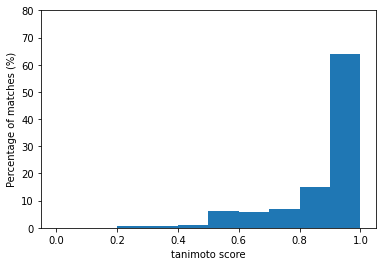

In [37]:
tanimoto_scores_df = load_pickled_file(tanimoto_scores_df_file)
plot_best_tanimoto_score_distribution(test_spectra_without_match, tanimoto_scores_df)

### Random results

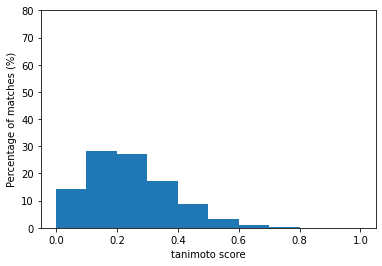

In [38]:
plot_average_tanimoto_distribution(test_spectra_without_match, tanimoto_scores_df)

# Compare MS2Deepscore to MS2Query
To make it easier to compare the performance of MS2Deepscore and MS2Query the recall is plotted versus the average tanimoto score. 

In [39]:
def avg_tanimoto_vs_percentage_found(selection_criteria_and_tanimoto, cut_off_maximum, steps, legend_label):
    cut_offs = {}
    percentages_found = []
    average_tanimoto_score = []
    for i in range(steps):
        cut_off = cut_off_maximum/steps * i
        selected_scores = [scores[1] for scores in selection_criteria_and_tanimoto if scores[0] > cut_off]
        percentages_found.append(len(selected_scores)/len(selection_criteria_and_tanimoto)*100)
        average_tanimoto_score.append(sum(selected_scores)/len(selected_scores))
    plt.plot(percentages_found, average_tanimoto_score, label = legend_label)
    plt.xlim(100,0)
    plt.ylim(0, 1)
    plt.xlabel("Percentage matches found")
    plt.ylabel("Average tanimoto score")
    plt.legend(loc = "lower right", title = "Select on highest:")
    plt.show

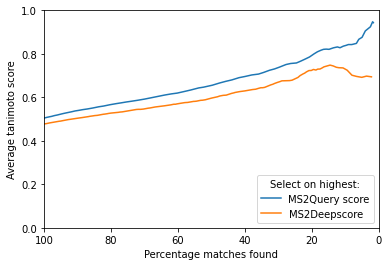

In [40]:
avg_tanimoto_vs_percentage_found(ms2query_and_tanimoto, 1.0, 100, "MS2Query score")
avg_tanimoto_vs_percentage_found(ms2ds_and_tanimoto, 1, 1000, "MS2Deepscore")

# Plot effect of preselection
As preselection MS2Deepscore is used. The number of spectra preselected with MS2Deepscore can be varried. The quality of matches found is plotted vs the number of spectra in the preselection. 

  1%|█▌                                                                                                                                                           | 1/100 [00:16<27:15, 16.53s/it]

0.4775700647980642


  2%|███▏                                                                                                                                                         | 2/100 [00:31<25:21, 15.53s/it]

0.5007966808146282


  3%|████▋                                                                                                                                                        | 3/100 [00:40<20:35, 12.74s/it]

0.49999087853693747


  4%|██████▎                                                                                                                                                      | 4/100 [00:48<16:55, 10.57s/it]

0.4994966493749956


  5%|███████▊                                                                                                                                                     | 5/100 [00:55<14:43,  9.29s/it]

0.4997751534172484


  6%|█████████▍                                                                                                                                                   | 6/100 [01:02<13:21,  8.53s/it]

0.49995010949168156


  7%|██████████▉                                                                                                                                                  | 7/100 [01:09<12:44,  8.22s/it]

0.4988803920805926


  8%|████████████▌                                                                                                                                                | 8/100 [01:17<12:24,  8.10s/it]

0.49948030460808374


  9%|██████████████▏                                                                                                                                              | 9/100 [01:24<11:56,  7.87s/it]

0.49840120491724155


 10%|███████████████▌                                                                                                                                            | 10/100 [01:32<11:37,  7.75s/it]

0.4985836643895577


 11%|█████████████████▏                                                                                                                                          | 11/100 [01:39<11:16,  7.60s/it]

0.4978709844801212


 12%|██████████████████▋                                                                                                                                         | 12/100 [01:46<10:55,  7.45s/it]

0.4984386026891225


 13%|████████████████████▎                                                                                                                                       | 13/100 [01:54<10:54,  7.52s/it]

0.4994795717059228


 14%|█████████████████████▊                                                                                                                                      | 14/100 [02:03<11:28,  8.00s/it]

0.49942815880420693


 15%|███████████████████████▍                                                                                                                                    | 15/100 [02:12<11:35,  8.19s/it]

0.49977780022641227


 16%|████████████████████████▉                                                                                                                                   | 16/100 [02:19<11:10,  7.98s/it]

0.49978914943165564


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [02:27<10:51,  7.85s/it]

0.500736434313897


 18%|████████████████████████████                                                                                                                                | 18/100 [02:35<10:49,  7.92s/it]

0.501386455449673


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [02:43<10:40,  7.91s/it]

0.5018042471718263


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [02:51<10:32,  7.90s/it]

0.5016934104933086


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [02:58<10:21,  7.87s/it]

0.5025185030681624


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [03:08<10:56,  8.42s/it]

0.5029290233207642


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [03:17<10:57,  8.53s/it]

0.5034041109244871


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [03:25<10:38,  8.39s/it]

0.5042823473530144


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [03:33<10:13,  8.18s/it]

0.503535656914244


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [03:41<09:59,  8.10s/it]

0.5039323125891885


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [03:48<09:41,  7.96s/it]

0.5053167039443113


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [03:56<09:29,  7.91s/it]

0.505705926654024


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [04:05<09:36,  8.12s/it]

0.50520612780602


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [04:13<09:31,  8.16s/it]

0.5051611797888473


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [04:20<09:11,  7.99s/it]

0.5046568473620815


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [04:28<08:48,  7.77s/it]

0.5050514316554329


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [04:35<08:32,  7.65s/it]

0.5053598294254319


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [04:43<08:27,  7.70s/it]

0.5059979624560111


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [04:50<08:16,  7.64s/it]

0.5056520170467846


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [04:59<08:20,  7.82s/it]

0.5059574065381275


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [05:06<08:02,  7.66s/it]

0.5065203667158655


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [05:15<08:22,  8.10s/it]

0.5079058021132284


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [05:23<08:04,  7.94s/it]

0.5079917957634681


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [05:29<07:37,  7.62s/it]

0.5080612951746026


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [05:40<08:24,  8.55s/it]

0.5085761883669334


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [05:48<08:06,  8.40s/it]

0.5082301888758698


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [05:58<08:28,  8.92s/it]

0.5085218635976481


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [06:07<08:15,  8.85s/it]

0.5085193801220432


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [06:15<07:50,  8.56s/it]

0.5080563034835189


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [06:23<07:30,  8.35s/it]

0.5077197104153364


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [06:30<07:11,  8.15s/it]

0.5079739161009706


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [06:38<06:58,  8.05s/it]

0.5089329706760402


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [06:47<06:53,  8.11s/it]

0.509014819689049


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [06:56<07:00,  8.41s/it]

0.5093993440380076


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [07:04<06:46,  8.30s/it]

0.5099724587634673


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [07:12<06:33,  8.20s/it]

0.509751651897673


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [07:19<06:20,  8.09s/it]

0.5096853447335289


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [07:28<06:14,  8.14s/it]

0.5103438461049068


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [07:35<06:00,  8.01s/it]

0.5109542396261643


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [07:43<05:51,  8.00s/it]

0.5110690560874861


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [07:53<06:03,  8.45s/it]

0.5109444307215242


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [08:02<06:00,  8.58s/it]

0.5109597886111205


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [08:10<05:48,  8.49s/it]

0.5110116201889415


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [08:19<05:40,  8.51s/it]

0.5108403548134768


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [08:27<05:30,  8.48s/it]

0.5110485383400813


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [08:35<05:14,  8.28s/it]

0.511258139944055


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [08:45<05:22,  8.70s/it]

0.5112784837054304


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [08:53<05:06,  8.52s/it]

0.5114651889778954


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [09:00<04:50,  8.30s/it]

0.5112080144755643


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [09:08<04:38,  8.19s/it]

0.5116945340575747


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [09:16<04:27,  8.12s/it]

0.5118299854222235


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [09:24<04:17,  8.06s/it]

0.5118980471198256


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [09:32<04:11,  8.10s/it]

0.5124115477180904


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [09:42<04:18,  8.63s/it]

0.5128369182108627


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [09:50<04:05,  8.47s/it]

0.513071747251989


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [09:59<03:56,  8.44s/it]

0.5133242131323953


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [10:07<03:45,  8.37s/it]

0.5133363362467467


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [10:15<03:38,  8.39s/it]

0.5130512479270394


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [10:24<03:28,  8.34s/it]

0.5136866681530472


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [10:32<03:18,  8.26s/it]

0.5136504513629488


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [10:41<03:19,  8.65s/it]

0.5133275627317444


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [10:50<03:08,  8.58s/it]

0.5134760198366509


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [10:58<02:57,  8.47s/it]

0.513336793655859


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [11:06<02:47,  8.39s/it]

0.513222969837489


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [11:15<02:41,  8.49s/it]

0.5128997688007189


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [11:23<02:31,  8.39s/it]

0.5122666702085218


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [11:31<02:21,  8.30s/it]

0.5126671180971168


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [11:41<02:20,  8.81s/it]

0.512452732442798


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [11:50<02:11,  8.75s/it]

0.5125669588584086


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [11:58<02:01,  8.68s/it]

0.5121692795633502


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [12:07<01:53,  8.72s/it]

0.5121832768506891


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [12:15<01:43,  8.60s/it]

0.5122968900277036


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 89/100 [12:24<01:34,  8.56s/it]

0.5125025760994053


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 90/100 [12:34<01:29,  8.97s/it]

0.5128828118171347


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 91/100 [12:42<01:19,  8.78s/it]

0.5126760065566414


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92/100 [12:51<01:10,  8.75s/it]

0.5122267470685645


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 93/100 [12:59<01:00,  8.67s/it]

0.5121290153023454


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 94/100 [13:08<00:52,  8.67s/it]

0.5120627435849535


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 95/100 [13:18<00:44,  9.00s/it]

0.5127259015421515


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [13:28<00:37,  9.50s/it]

0.5127628883757758


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97/100 [13:40<00:30, 10.16s/it]

0.5125524320065175


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [13:49<00:19,  9.83s/it]

0.512312689684276


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [13:58<00:09,  9.63s/it]

0.5130822518523591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:07<00:00,  8.48s/it]

0.5129329887724577
[0.4775700647980642, 0.5007966808146282, 0.49999087853693747, 0.4994966493749956, 0.4997751534172484, 0.49995010949168156, 0.4988803920805926, 0.49948030460808374, 0.49840120491724155, 0.4985836643895577, 0.4978709844801212, 0.4984386026891225, 0.4994795717059228, 0.49942815880420693, 0.49977780022641227, 0.49978914943165564, 0.500736434313897, 0.501386455449673, 0.5018042471718263, 0.5016934104933086, 0.5025185030681624, 0.5029290233207642, 0.5034041109244871, 0.5042823473530144, 0.503535656914244, 0.5039323125891885, 0.5053167039443113, 0.505705926654024, 0.50520612780602, 0.5051611797888473, 0.5046568473620815, 0.5050514316554329, 0.5053598294254319, 0.5059979624560111, 0.5056520170467846, 0.5059574065381275, 0.5065203667158655, 0.5079058021132284, 0.5079917957634681, 0.5080612951746026, 0.5085761883669334, 0.5082301888758698, 0.5085218635976481, 0.5085193801220432, 0.5080563034835189, 0.5077197104153364, 0.5079739161009706, 0.5089329706760402, 0.509014819689049, 

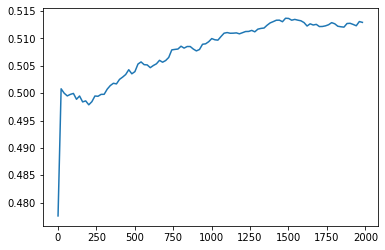

In [58]:
from tqdm import tqdm
def average_tanimoto_for_nr_preselected(scores, nr_of_spectra_preselection):
    selected_matches = {}
    for query_spectrum_id in scores:
        scores_df = scores[query_spectrum_id]
        selected_matches[query_spectrum_id] = scores_df.loc[scores_df["ms2ds_score"].nlargest(nr_of_spectra_preselection).index].sort_values("ms2query_model_prediction", ascending = False)
    tanimoto_scores = select_best_match_and_calculate_tanimoto_score(selected_matches, tanimoto_scores_df_file, test_spectra_without_match, sqlite_file)
    average_tanimoto_score = sum([scores[1] for scores in tanimoto_scores])/len(tanimoto_scores)
    return average_tanimoto_score 

def plot_dependency_on_nr_preselected(results):
    average_tanimoto_list = []
    cut_off = []
    for i in tqdm(range(1, 2000, 20)):
        average_tanimoto = average_tanimoto_for_nr_preselected(results, i)
        average_tanimoto_list.append(average_tanimoto)
        cut_off.append(i)
        print(average_tanimoto)
    print(average_tanimoto_list)
    print(cut_off)
    plt.plot(cut_off, average_tanimoto_list)

results_top_2000 = load_pickled_file("../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra_dropout_reg_top_2000.pickle")
plot_dependency_on_nr_preselected(results_top_2000)


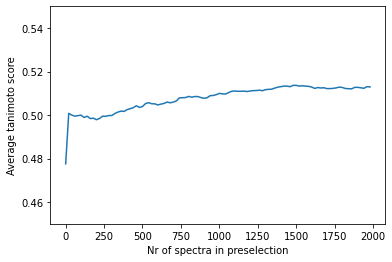

In [61]:
tanimoto_scores = [0.4775700647980642, 0.5007966808146282, 0.49999087853693747, 0.4994966493749956, 0.4997751534172484, 0.49995010949168156, 0.4988803920805926, 0.49948030460808374, 0.49840120491724155, 0.4985836643895577, 0.4978709844801212, 0.4984386026891225, 0.4994795717059228, 0.49942815880420693, 0.49977780022641227, 0.49978914943165564, 0.500736434313897, 0.501386455449673, 0.5018042471718263, 0.5016934104933086, 0.5025185030681624, 0.5029290233207642, 0.5034041109244871, 0.5042823473530144, 0.503535656914244, 0.5039323125891885, 0.5053167039443113, 0.505705926654024, 0.50520612780602, 0.5051611797888473, 0.5046568473620815, 0.5050514316554329, 0.5053598294254319, 0.5059979624560111, 0.5056520170467846, 0.5059574065381275, 0.5065203667158655, 0.5079058021132284, 0.5079917957634681, 0.5080612951746026, 0.5085761883669334, 0.5082301888758698, 0.5085218635976481, 0.5085193801220432, 0.5080563034835189, 0.5077197104153364, 0.5079739161009706, 0.5089329706760402, 0.509014819689049, 0.5093993440380076, 0.5099724587634673, 0.509751651897673, 0.5096853447335289, 0.5103438461049068, 0.5109542396261643, 0.5110690560874861, 0.5109444307215242, 0.5109597886111205, 0.5110116201889415, 0.5108403548134768, 0.5110485383400813, 0.511258139944055, 0.5112784837054304, 0.5114651889778954, 0.5112080144755643, 0.5116945340575747, 0.5118299854222235, 0.5118980471198256, 0.5124115477180904, 0.5128369182108627, 0.513071747251989, 0.5133242131323953, 0.5133363362467467, 0.5130512479270394, 0.5136866681530472, 0.5136504513629488, 0.5133275627317444, 0.5134760198366509, 0.513336793655859, 0.513222969837489, 0.5128997688007189, 0.5122666702085218, 0.5126671180971168, 0.512452732442798, 0.5125669588584086, 0.5121692795633502, 0.5121832768506891, 0.5122968900277036, 0.5125025760994053, 0.5128828118171347, 0.5126760065566414, 0.5122267470685645, 0.5121290153023454, 0.5120627435849535, 0.5127259015421515, 0.5127628883757758, 0.5125524320065175, 0.512312689684276, 0.5130822518523591, 0.5129329887724577]
nr_of_spectra_selected = [1, 21, 41, 61, 81, 101, 121, 141, 161, 181, 201, 221, 241, 261, 281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541, 561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821, 841, 861, 881, 901, 921, 941, 961, 981, 1001, 1021, 1041, 1061, 1081, 1101, 1121, 1141, 1161, 1181, 1201, 1221, 1241, 1261, 1281, 1301, 1321, 1341, 1361, 1381, 1401, 1421, 1441, 1461, 1481, 1501, 1521, 1541, 1561, 1581, 1601, 1621, 1641, 1661, 1681, 1701, 1721, 1741, 1761, 1781, 1801, 1821, 1841, 1861, 1881, 1901, 1921, 1941, 1961, 1981]
plt.xlabel("Nr of spectra in preselection")
plt.ylabel("Average tanimoto score")
plt.ylim(0.45,0.55)
plt.plot(nr_of_spectra_selected, tanimoto_scores)
plt.show()

1.0


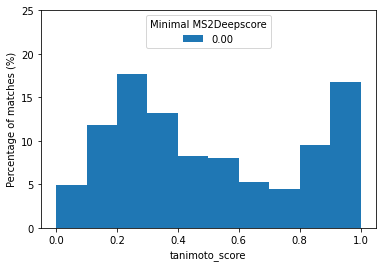

In [37]:
plot_tanimoto_score_distribution_for_ms2query_cut_offs(ms2ds_and_tanimoto, [0], "Minimal MS2Deepscore")


# Format graphs with constant axises for report

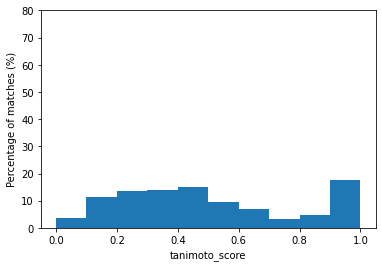

In [49]:
bins = np.linspace(0, 1, 11)

weight_to_convert_to_percentage = 100/len(ms2query_and_tanimoto)


selected_scores = [scores[1] for scores in ms2query_and_tanimoto]
weights = [weight_to_convert_to_percentage] * len(selected_scores)

plt.hist(selected_scores, bins, weights = weights)

plt.xlabel("tanimoto_score")
plt.ylabel("Percentage of matches (%)")
plt.ylim(0, 80)
plt.show()

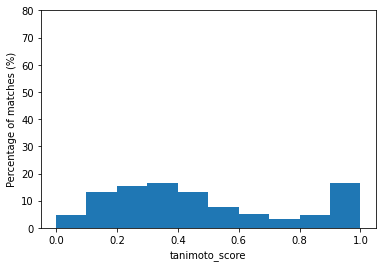

In [51]:
bins = np.linspace(0, 1, 11)

weight_to_convert_to_percentage = 100/len(ms2ds_and_tanimoto)


selected_scores = [scores[1] for scores in ms2ds_and_tanimoto]
weights = [weight_to_convert_to_percentage] * len(selected_scores)

plt.hist(selected_scores, bins, weights = weights)

plt.xlabel("tanimoto_score")
plt.ylabel("Percentage of matches (%)")
plt.ylim(0, 80)
plt.show()

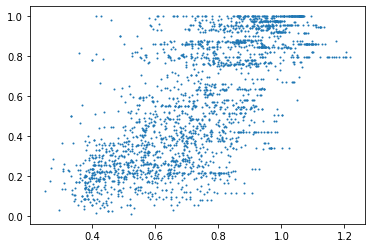

In [65]:
ms2query_list = []
tanimoto_list = []
for ms2query, tanimoto in ms2query_and_tanimoto:
    ms2query_list.append(ms2query)
    tanimoto_list.append(tanimoto)
plt.scatter(ms2query_list, tanimoto_list, s = 1)

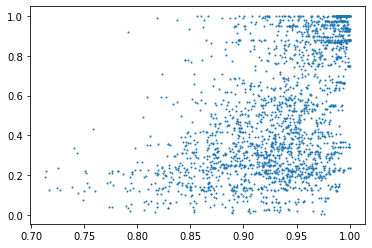

In [16]:
ms2ds_list = []
tanimoto_list = []
for ms2ds, tanimoto in ms2ds_and_tanimoto:
    ms2ds_list.append(ms2ds)
    tanimoto_list.append(tanimoto)
plt.scatter(ms2ds_list, tanimoto_list, s = 1)

# Select spectra to show examples

In [55]:
from ms2query.query_from_sqlite_database import get_metadata_from_sqlite
results = load_pickled_file("../downloads/gnps_210409/train_ms2query_model/results_with_match_all_scores_test_spectra_dropout_reg.pickle")

tanimoto_scores = load_pickled_file(tanimoto_scores_df_file)


query_smiles = {}
for query_spectrum in test_spectra_without_match:
    query_spectrum_id = query_spectrum.get("spectrum_id")
    best_result = results[query_spectrum_id].iloc[0]
    if best_result["ms2query_model_prediction"] > 0.8:
        best_analog = best_result.name
        query_spectrum_smiles = query_spectrum.get("smiles")
        query_spectrum_inchikey = query_spectrum.get("inchikey")[:14]
        
        analog_metadata = get_metadata_from_sqlite(sqlite_file, [best_analog])[best_analog]
        analog_smiles = analog_metadata["smiles"]
        analog_inchikey = analog_metadata["inchikey"][:14]
        
        tanimoto_score = tanimoto_scores.loc[query_spectrum_inchikey, analog_inchikey]
        
        query_smiles[query_spectrum_smiles] = (analog_smiles, tanimoto_score, best_result["ms2query_model_prediction"])

for query_smile in query_smiles:
    print("Query smile:")
    print(query_smile)
    print(query_smiles[query_smile][0])
    print(query_smiles[query_smile][1])
    print(query_smiles[query_smile][2])


Query smile:
O=C1OC=2C=C(O)C=CC2C=C1
O=C1OC=2C=CC=CC2C(O)=C1
0.8032345013477089
0.8086315989494324
Query smile:
CC1OC(O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3CC=C3C5CC(C)(C)CC[C@]5(C(=O)OC5OC(CO)C(OC6OC(COC7OCC(O)C(O)C7O)C(O)C(O)C6O)C(O)C5O)CC[C@]34C)C2(C)C)C(O)C(O)C1OC1OCC(OC2OCC(O)C(O)C2O)C(O)C1O
C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@@H]3OC[C@@H](O)[C@H](O)[C@H]3O)[C@@H](CO)O[C@H]2O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3CC=C3[C@@H]5CC(C)(C)CC[C@]5(C(=O)O[C@@H]5OC[C@H](O)[C@H](O)[C@H]5O[C@@H]5O[C@@H](C)[C@H](O[C@@H]6O[C@H](CO)[C@@H](O)[C@H](O)[C@H]6O)[C@H](O)[C@H]5O)CC[C@]34C)C2(C)C)[C@H](O)[C@H](O)[C@H]1O
0.9687875150060024
0.8603425025939941
Query smile:
CC1OC(O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3C\C=C/5C6CC(C)(C)CC[C@@]6(CC[C@@]45C)C(=O)OC7OC(CO)C(OC8OC(COC9OCC(O)C(O)C9O)C(O)C(O)C8O)C(O)C7O)C2(C)C)C(O)C(O)C1OC%10OCC(OC%11OCC(O)C(O)C%11O)C(O)C%10O
C[C@@H]1O[C@@H](O[C@@H]2[C@@H](O)[C@H](O[C@@H]3OC[C@@H](O)[C@H](O)[C@H]3O)[C@@H](CO)O[C@H]2O[C@H]2CC[C@@]3(C)C(CC[C@]4(C)C3CC=C3[C@@H]5CC(C)(C)CC[C@]5(C(